In [1]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
from mhcflurry import dataset
from mhcflurry.dataset import Dataset
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.optimizers import Adam 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

Using Theano backend.


In [2]:
ds = Dataset.from_csv("bdata.2009.mhci.public.1.txt")
ds_h = ds.slice(ds.alleles == 'HLA-A0201')

In [3]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq, max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))
y[y<0]=0

def first_and_last_three(Y):
    k = np.count_nonzero(Y)
    return np.concatenate([Y[:3],Y[-3+k:k]])
def first_and_last_four(Y):
    k = np.count_nonzero(Y)
    return np.concatenate([Y[:4],Y[-4+k:k]])
def first_and_last_two(Y):
    k = np.count_nonzero(Y)
    return np.concatenate([Y[:2],Y[-2+k:k]])
X_44 = np.apply_along_axis(first_and_last_four,1,X)
X_33 = np.apply_along_axis(first_and_last_three,1,X)
X_22 = np.apply_along_axis(first_and_last_two,1,X)

In [4]:
X_44[1]

array([ 1,  1,  1, 16,  7, 15,  9, 18])

In [5]:
X_44[1][1]

1

In [6]:
len(df_h)

9565

In [7]:
def regroup_together(affinities, weights , original_indices):
    affinities = affinities.ravel()
    weights = weights.ravel()
    
    assert affinities.shape == weights.shape, "%s should be %s" % (affinities.shape, weights.shape)
    assert affinities.shape == original_indices.shape
    assert len(affinities) == len(affinities.ravel())
    
    weighted_affinities = (affinities * weights)
    index_set = set(original_indices)
    n_indices = len(index_set)
    result_order = {original_index: i for (i, original_index) in enumerate(sorted(index_set))}
    result = np.zeros(n_indices)
    for i, x in enumerate(weighted_affinities):
        result_idx = result_order[original_indices[i]]
        result[result_idx] += x
    return result

def slicing(dataset, index, i):
    return dataset.slice(index).kmer_index_encoding()[i]

def label_transform(array):
    result = 1-np.log(array)/math.log(50000)
    result[result<0]=0
    return result

def index_to_hotshot_encoding(index_encoded_nine_mer):
    result = np.zeros((9,21))
    for position, amino_acid in enumerate(index_encoded_nine_mer):
        result[position][amino_acid]= 1
    return result.flatten()

def real_labels(dataset,index):
    
    y = label_transform(slicing(dataset,index,1))
    weights = slicing(dataset,index,2)
    original_indices = slicing(dataset,index,3)
    
    return regroup_together(y, weights , original_indices)

def fit(model,dataset,index, neural_network = False, hotshot = False): # to be left out or modified 
    
    X = slicing(dataset,index,0)
    
    if (hotshot == True):
        X = np.apply_along_axis(index_to_hotshot_encoding, 1, X)
        
    y = label_transform(slicing(dataset,index,1))
    weights = slicing(dataset,index,2)
    
    if (neural_network == True):
        model.fit(X, y, sample_weight = weights, batch_size = 16, nb_epoch = 1)
    else: 
        model.fit(X, y, sample_weight = weights)
        
def predict(model, dataset, index, hotshot = False):
    
    X = slicing(dataset,index,0)
    
    if (hotshot == True):
        X = np.apply_along_axis(index_to_hotshot_encoding, 1, X)
        
    weights = slicing(dataset,index,2)
    original_indices = slicing(dataset,index,3)
    
    return regroup_together(model.predict(X), weights , original_indices)

def AUC(model, dataset, index, hotshot = False):
        
    real_affinity = measured_affinity_less_than(real_labels(dataset,index),500)
    predicted_affinity = predict(model, dataset, index, hotshot = hotshot)
    
    return roc_auc_score(real_affinity, predicted_affinity)

def AUC_simple(model, features, labels, index):
    real_affinity = measured_affinity_less_than(labels[index],500)
    predicted_affinity = model.predict(features[index])
    
    return roc_auc_score(real_affinity, predicted_affinity)

In [8]:
def split_by_length(X,index,length=9):
    length_idx = np.array([i for i in index if (np.count_nonzero(X[i])==length)])
    non_length_idx = np.array([i for i in index if (np.count_nonzero(X[i])!=length)])
    return index, length_idx, non_length_idx

In [9]:
def random_dropout_prediction(model, peptide):
    peptide_copy = peptide 
    prediction = np.zeros(len(peptide))
    for i in range(len(peptide)):
        peptide_copy = peptide
        peptide_copy[i] = 0
        prediction[i] = model.predict(peptide_copy.T)
    return prediction.mean()

def random_dropout_array_prediction(model,X):
    results = np.zeros(len(X))
    for i,peptide in enumerate(list(X)):
        results[i]= random_dropout_prediction(model, peptide)
    return results

def AUC_random_dropout(model, features, labels, index):
    real_affinity = measured_affinity_less_than(labels[index],500)
    predicted_affinity = random_dropout_array_prediction(model, features[index])
    
    return roc_auc_score(real_affinity, predicted_affinity)

In [11]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 40
epoch = 0


nn_aucs = np.zeros((6, folds,n_epochs))
lstm_aucs = np.zeros((6, folds,n_epochs))
kmer_lstm_aucs = np.zeros((6, folds,n_epochs))
nn_44_aucs = np.zeros((6, folds,n_epochs))
lstm_44_aucs = np.zeros((6, folds,n_epochs))


for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):
    
    list_index = split_by_length(X,train_idx,length=9)+split_by_length(X,test_idx,length=9)
    
    
    
    # neural net
    nn = Sequential()
    nn.add(Embedding(input_dim = 21, input_length =9, output_dim= 32))
    nn.add(Flatten())
    nn.add(Dense(10, init='glorot_uniform', activation='sigmoid'))
    nn.add(Dense(1, init='glorot_uniform', activation='sigmoid'))
    
    nn.compile(optimizer = 'adam', loss='mean_squared_error')
    
    
    # lstm 
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm = Model(input = sequence, output = output)
    adam = Adam(lr = 0.01)
    lstm.compile(optimizer = adam, loss='mean_squared_error')
    
    # kmer lstm 
    sequence = Input( shape= (9, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 9, output_dim= 32, mask_zero = False)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    kmer_lstm = Model(input = sequence, output = output)
    kmer_adam = Adam(lr = 0.01)
    kmer_lstm.compile(optimizer = kmer_adam, loss='mean_squared_error')
    
    
    # neural net
    nn_44 = Sequential()
    nn_44.add(Embedding(input_dim = 21, input_length =8, output_dim= 32))
    nn_44.add(Flatten())
    nn_44.add(Dense(10, init='glorot_uniform', activation='sigmoid'))
    nn_44.add(Dense(1, init='glorot_uniform', activation='sigmoid'))
    
    nn_44.compile(optimizer = 'adam', loss='mean_squared_error')
    
    
    # lstm 
    sequence = Input( shape= (8, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 8, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_44 = Model(input = sequence, output = output)
    adam_44 = Adam(lr = 0.01)
    lstm_44.compile(optimizer = adam_44, loss='mean_squared_error')
      
    
    for epoch in range(n_epochs):
        
        
        # nn
        fit(nn,ds_h, train_idx, neural_network = True, hotshot = False)
        for k, index in enumerate(list_index):
            nn_aucs[k][i][epoch] = AUC(nn,ds_h,index)    
        
        #lstm 
        adam.lr.set_value(0.01*(1+epoch)**(-2))
        lstm.fit(X[train_idx],y[train_idx], batch_size = 16, nb_epoch = 1)
        for k, index in enumerate(list_index):
            lstm_aucs[k][i][epoch] = AUC_simple(lstm, X, y, index)
            
        kmer_adam.lr.set_value(0.01*(1+epoch)**(-2))
        fit(kmer_lstm, ds_h, train_idx, neural_network = True, hotshot = False)
        for k, index in enumerate(list_index):
            kmer_lstm_aucs[k][i][epoch] = AUC(kmer_lstm, ds_h, index)
            
            
        # nn_44
        nn_44.fit(X_44[train_idx],y[train_idx],batch_size = 16, nb_epoch = 1 )
        for k, index in enumerate(list_index):
            nn_44_aucs[k][i][epoch] = AUC_simple(nn_44,X_44, y,index)    
        
        #lstm_44 
        adam_44.lr.set_value(0.01*(1+epoch)**(-2))
        lstm_44.fit(X_44[train_idx],y[train_idx], batch_size = 16, nb_epoch = 1)
        for k, index in enumerate(list_index):
            lstm_44_aucs[k][i][epoch] = AUC_simple(lstm_44, X_44, y, index)

        print("allmers:", nn_aucs[3][i][epoch], kmer_lstm_aucs[3][i][epoch], lstm_aucs[3][i][epoch], i, epoch)  
        print("9 mers:", nn_aucs[4][i][epoch],  kmer_lstm_aucs[4][i][epoch], lstm_aucs[4][i][epoch], i, epoch)  
        print("non 9 mers:", nn_aucs[5][i][epoch], kmer_lstm_aucs[5][i][epoch], lstm_aucs[5][i][epoch], i , epoch)  

    

Epoch 1/1
22007/22007 [==============================] - 1s - loss: 0.0142     
Epoch 1/1
6376/6376 [==============================] - 15s - loss: 0.0429    
Epoch 1/1
22007/22007 [==============================] - 27s - loss: 0.0127    
Epoch 1/1
6376/6376 [==============================] - 0s - loss: 0.0588     
Epoch 1/1
6376/6376 [==============================] - 9s - loss: 0.0438     
allmers: 0.936494960505 0.924849846819 0.927271585501 0 0
9 mers: 0.947140804487 0.932357091633 0.944323206775 0 0
non 9 mers: 0.905465139642 0.903278611022 0.877046177121 0 0
Epoch 1/1
22007/22007 [==============================] - 2s - loss: 0.0086     
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0275    
Epoch 1/1
22007/22007 [==============================] - 29s - loss: 0.0091    
Epoch 1/1
6376/6376 [==============================] - 0s - loss: 0.0311     
Epoch 1/1
6376/6376 [==============================] - 8s - loss: 0.0289     
allmers: 0.944926639126 0.9447813078

# LSTM vs kmer LSTM vs FFNN vs LSTM44 vs FFNN44

## fold 1

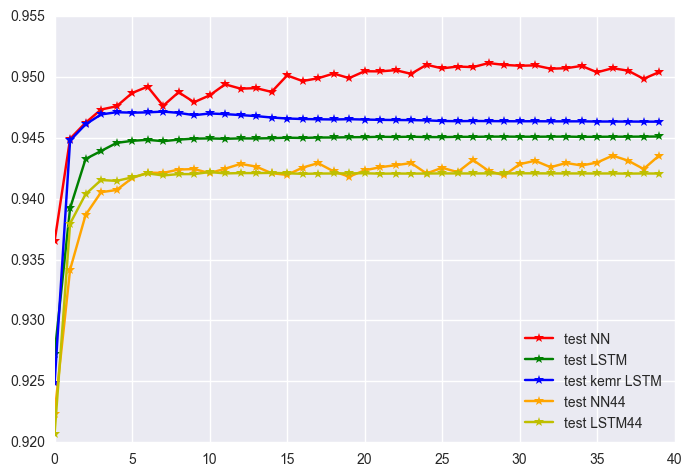

In [21]:
plt.plot( np.arange(0,40,1), nn_aucs[3,0,0:40],color='r',marker='*', linestyle='-', label ="test NN ")
plt.plot( np.arange(0,40,1), lstm_aucs[3,0,0:40],color='g',marker='*', linestyle='-', label ="test LSTM ")
plt.plot( np.arange(0,40,1), kmer_lstm_aucs[3,0,0:40],color='b',marker='*', linestyle='-', label ="test kemr LSTM")
plt.plot( np.arange(0,40,1), nn_44_aucs[3,0,0:40],color='orange',marker='*', linestyle='-', label ="test NN44")
plt.plot( np.arange(0,40,1), lstm_44_aucs[3,0,0:40],color='y',marker='*', linestyle='-', label ="test LSTM44")
plt.legend(loc=4)

## fold 2

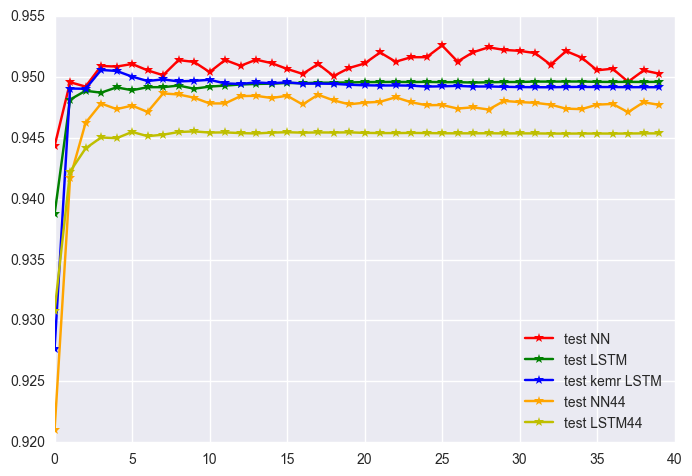

In [22]:
plt.plot( np.arange(0,40,1), nn_aucs[3,1,0:40],color='r',marker='*', linestyle='-', label ="test NN ")
plt.plot( np.arange(0,40,1), lstm_aucs[3,1,0:40],color='g',marker='*', linestyle='-', label ="test LSTM ")
plt.plot( np.arange(0,40,1), kmer_lstm_aucs[3,1,0:40],color='b',marker='*', linestyle='-', label ="test kemr LSTM")
plt.plot( np.arange(0,40,1), nn_44_aucs[3,1,0:40],color='orange',marker='*', linestyle='-', label ="test NN44")
plt.plot( np.arange(0,40,1), lstm_44_aucs[3,1,0:40],color='y',marker='*', linestyle='-', label ="test LSTM44")
plt.legend(loc=4)

## fold 3

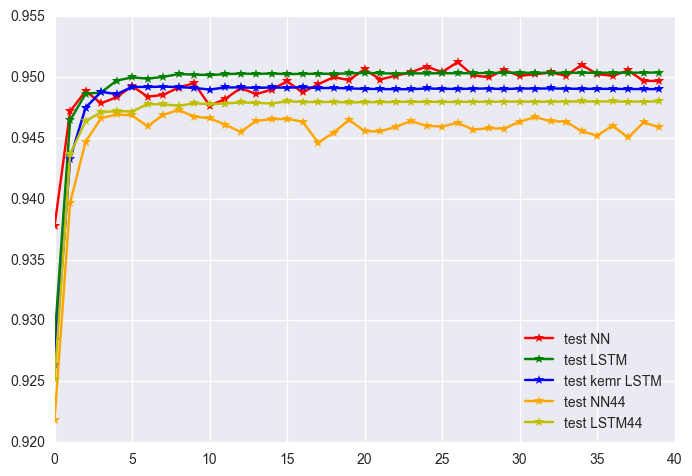

In [24]:
plt.plot( np.arange(0,40,1), nn_aucs[3,2,0:40],color='r',marker='*', linestyle='-', label ="test NN ")
plt.plot( np.arange(0,40,1), lstm_aucs[3,2,0:40],color='g',marker='*', linestyle='-', label ="test LSTM ")
plt.plot( np.arange(0,40,1), kmer_lstm_aucs[3,2,0:40],color='b',marker='*', linestyle='-', label ="test kemr LSTM")
plt.plot( np.arange(0,40,1), nn_44_aucs[3,2,0:40],color='orange',marker='*', linestyle='-', label ="test NN44")
plt.plot( np.arange(0,40,1), lstm_44_aucs[3,2,0:40],color='y',marker='*', linestyle='-', label ="test LSTM44")
plt.legend(loc=4)

In [32]:
kmer_lstm_aucs[3,:,:].mean(axis=0)

array([ 0.926299  ,  0.9457056 ,  0.94753596,  0.94875784,  0.94872511,
        0.94875629,  0.94864284,  0.9487179 ,  0.94861656,  0.94854372,
        0.9485742 ,  0.94851569,  0.94847794,  0.94847659,  0.94842804,
        0.94841876,  0.94838217,  0.94835097,  0.94834698,  0.94831363,
        0.94827755,  0.94825895,  0.94825143,  0.94824381,  0.94822935,
        0.94821176,  0.94821287,  0.94821077,  0.94821204,  0.94818478,
        0.94818964,  0.9481877 ,  0.94818511,  0.94818789,  0.94818338,
        0.94817604,  0.9481765 ,  0.94816642,  0.94816406,  0.94815901])

In [30]:
lstm_44_aucs[3,0,:]

array([ 0.92066395,  0.93796151,  0.94037158,  0.94153378,  0.94146426,
        0.94175088,  0.94207833,  0.94191102,  0.94201912,  0.94202136,
        0.94218867,  0.94207698,  0.94210345,  0.94210345,  0.94212004,
        0.94208819,  0.94204244,  0.94206532,  0.9420707 ,  0.94208595,
        0.94208864,  0.9420559 ,  0.94206622,  0.94206173,  0.94206711,
        0.94207676,  0.94207564,  0.9420716 ,  0.94208012,  0.94207519,
        0.94208685,  0.94208147,  0.94207743,  0.94207384,  0.94207339,
        0.94207025,  0.94207384,  0.94205994,  0.94207294,  0.94206577])

## 3-fold CV

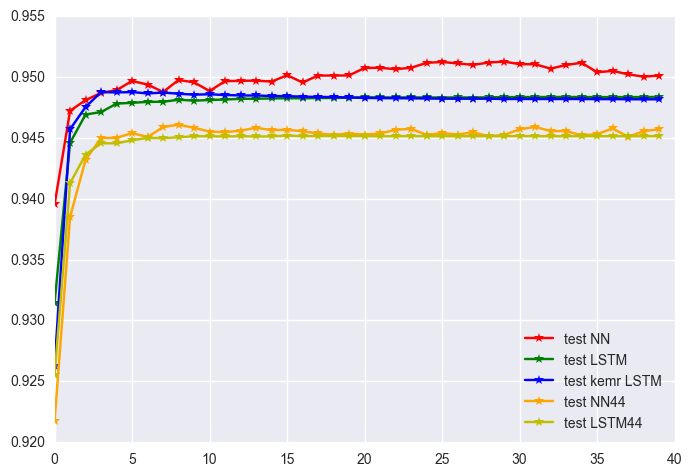

In [33]:
plt.plot( np.arange(0,40,1), nn_aucs[3,:,:].mean(axis=0),color='r',marker='*', linestyle='-', label ="test NN ")
plt.plot( np.arange(0,40,1), lstm_aucs[3,:,:].mean(axis=0),color='g',marker='*', linestyle='-', label ="test LSTM ")
plt.plot( np.arange(0,40,1), kmer_lstm_aucs[3,:,:].mean(axis=0),color='b',marker='*', linestyle='-', label ="test kemr LSTM")
plt.plot( np.arange(0,40,1), nn_44_aucs[3,:,:].mean(axis=0),color='orange',marker='*', linestyle='-', label ="test NN44")
plt.plot( np.arange(0,40,1), lstm_44_aucs[3,:,:].mean(axis=0),color='y',marker='*', linestyle='-', label ="test LSTM44")
plt.legend(loc=4)

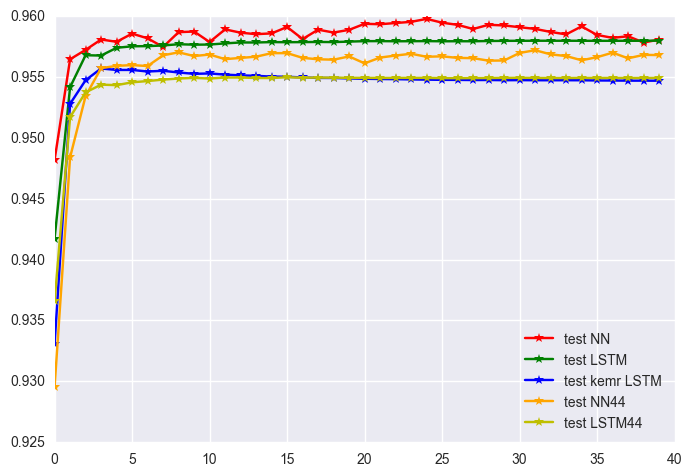

In [34]:
plt.plot( np.arange(0,40,1), nn_aucs[4,:,:].mean(axis=0),color='r',marker='*', linestyle='-', label ="test NN ")
plt.plot( np.arange(0,40,1), lstm_aucs[4,:,:].mean(axis=0),color='g',marker='*', linestyle='-', label ="test LSTM ")
plt.plot( np.arange(0,40,1), kmer_lstm_aucs[4,:,:].mean(axis=0),color='b',marker='*', linestyle='-', label ="test kemr LSTM")
plt.plot( np.arange(0,40,1), nn_44_aucs[4,:,:].mean(axis=0),color='orange',marker='*', linestyle='-', label ="test NN44")
plt.plot( np.arange(0,40,1), lstm_44_aucs[4,:,:].mean(axis=0),color='y',marker='*', linestyle='-', label ="test LSTM44")
plt.legend(loc=4)

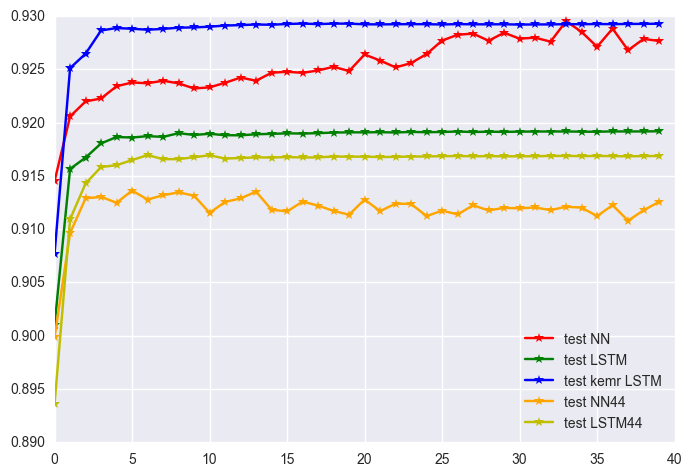

In [35]:
plt.plot( np.arange(0,40,1), nn_aucs[5,:,:].mean(axis=0),color='r',marker='*', linestyle='-', label ="test NN ")
plt.plot( np.arange(0,40,1), lstm_aucs[5,:,:].mean(axis=0),color='g',marker='*', linestyle='-', label ="test LSTM ")
plt.plot( np.arange(0,40,1), kmer_lstm_aucs[5,:,:].mean(axis=0),color='b',marker='*', linestyle='-', label ="test kemr LSTM")
plt.plot( np.arange(0,40,1), nn_44_aucs[5,:,:].mean(axis=0),color='orange',marker='*', linestyle='-', label ="test NN44")
plt.plot( np.arange(0,40,1), lstm_44_aucs[5,:,:].mean(axis=0),color='y',marker='*', linestyle='-', label ="test LSTM44")
plt.legend(loc=4)